# all_models.ipynb 

Here we will run our data through all models to see which one performs best

In [26]:
import pandas as pd
import os
import math
import argparse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris, load_wine, load_digits, load_breast_cancer, load_diabetes
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

folder = "data/CombinedPricePlayerCountHistory"
game_dfs = []

for filename in os.listdir(folder):
    if filename == "readme.md":
        continue

    # Construct filenames
    fullpath = os.path.join(folder, filename)
    appId, garbage_collector = os.path.splitext(filename)

    # Create data frame for each csv
    df = pd.read_csv(fullpath)
    df['appid'] = appId
    # Put appid first for visual pleasure
    cols = ['appid'] + [col for col in df if col != 'appid']
    df = df[cols]
    game_dfs.append(df)

# Combine them into one csv we can use to train
combined_df = pd.concat(game_dfs, ignore_index=True)

#pull in the rest of our merged info
merged_info_df = pd.read_csv("merged_info.csv")

#format combined_df
combined_df['appid'] = combined_df['appid'].astype('int64')
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

#merge combined_df and merged_info_df
full_df = combined_df.merge(merged_info_df,on='appid')

#drop redundant columns
full_df = full_df.drop('type', axis=1)
full_df = full_df.drop('freetoplay', axis=1)

#format dates, drop ones that do not follow format
full_df['releasedate'] = pd.to_datetime(full_df['releasedate'], format='%d-%b-%y',errors='coerce')
full_df = full_df.dropna(subset=['releasedate'])

#numerically encode string columns (name, dev, pub)
label_encoder = LabelEncoder()
full_df['name'] = label_encoder.fit_transform(full_df['name'])
full_df['developer'] = label_encoder.fit_transform(full_df['developer'])
full_df['publisher'] = label_encoder.fit_transform(full_df['publisher'])

####make discount into a binary classifier
full_df['Discount'] = full_df['Discount'].apply(lambda x: 1 if x != 0 else 0)

#to check
print(full_df)

        appid       Date  Playercount  Initialprice  Finalprice  Discount  \
0          10 2019-04-07        10925          9.99        9.99         0   
1          10 2019-04-08         9277          9.99        9.99         0   
2          10 2019-04-09         9219          9.99        9.99         0   
3          10 2019-04-10         8993          9.99        9.99         0   
4          10 2019-04-11         9168          9.99        9.99         0   
...       ...        ...          ...           ...         ...       ...   
597477  98800 2020-08-08           35          4.99        4.99         0   
597478  98800 2020-08-09           38          4.99        4.99         0   
597479  98800 2020-08-10           32          4.99        4.99         0   
597480  98800 2020-08-11           33          4.99        4.99         0   
597481  98800 2020-08-12           34          4.99        4.99         0   

        name releasedate  developer  publisher  
0        197  2000-11-01  

In [27]:
#read in csv, convert date column to datetime object
full_df['Date'] = pd.to_datetime(full_df['Date'])

#2/3 samples train/test split
samples = len(full_df)
split = math.floor(samples * (2/3))

#split at date 2/3 of the way through entry by using "split" to index into the df, get the date, and use that
split_date = full_df.iloc[split]['Date']
split_date = pd.to_datetime(split_date)
train_data = full_df[full_df['Date'] < split_date]
test_data = full_df[full_df['Date'] >= split_date]

#Considering 'Finalprice' spoils whether or not there is a discount/it's amount so we omit that feature
#Set up training data
X_train = train_data[['Date', 'Playercount', 'Initialprice']]
y_train = train_data['Discount']

#Set up testing data
X_test = test_data[['Date', 'Playercount', 'Initialprice']]
y_test = test_data['Discount']

print(X_test)
print(y_test)

#convert dates into something more compatible with our model (dates are not ML friendly)
X_train['DayOfWeek'] = X_train['Date'].dt.dayofweek
X_train['Month'] = X_train['Date'].dt.month
X_train['Year'] = X_train['Date'].dt.year
X_test['DayOfWeek'] = X_test['Date'].dt.dayofweek
X_test['Month'] = X_test['Date'].dt.month
X_test['Year'] = X_test['Date'].dt.year

#drop the old date
X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

             Date  Playercount  Initialprice
317    2020-02-18         8614          9.99
318    2020-02-19         8889          9.99
319    2020-02-20         9061          9.99
320    2020-02-21         9514          9.99
321    2020-02-22        10538          9.99
...           ...          ...           ...
597477 2020-08-08           35          4.99
597478 2020-08-09           38          4.99
597479 2020-08-10           32          4.99
597480 2020-08-11           33          4.99
597481 2020-08-12           34          4.99

[211216 rows x 3 columns]
317       0
318       0
319       0
320       0
321       0
         ..
597477    0
597478    0
597479    0
597480    0
597481    0
Name: Discount, Length: 211216, dtype: int64


Setup the models

In [28]:
names = [
    "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(3),
    # SVC(kernel="linear", C=0.025),
    # SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
]

for i in range(len(classifiers)):
    cn = names[i]
    clf = classifiers[i]
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_predict)

    y_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_predict)

    print("Name:", cn)
    print("Training:", train_acc)
    print("Testing:", test_acc)
    print("\n")   


Name: Nearest Neighbors
Training: 0.8550340837918121
Testing: 0.8223240663586092


Name: Decision Tree
Training: 0.8359014207860452
Testing: 0.8609717066888872


Name: Random Forest
Training: 0.8304672455150511
Testing: 0.8609717066888872


Name: Neural Net
Training: 0.8303373034951804
Testing: 0.8609717066888872


Name: AdaBoost
Training: 0.831280682559442
Testing: 0.8609906446481327


Name: Naive Bayes
Training: 0.829438104717675
Testing: 0.8596460495417014




We saw that a decision tree, random forest, and neural net all had pretty good accuracies. First we will hyper parameters on decision trees to see if we can get better results.

In [29]:
depths = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 100]
scores = {}
dt_scores = {}

print("Decision Trees")
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth,random_state=42)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_predict)

    y_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_predict)

    dt_scores[depth] = test_acc

    print("Depth:", depth)
    print("Training:", train_acc)
    print("Testing:", test_acc)
    print("\n")   

print("Best Depth:", max(dt_scores, key=lambda k: dt_scores[k]))
    

Decision Trees
Depth: 1
Training: 0.8303373034951804
Testing: 0.8609717066888872


Depth: 2
Training: 0.8322162651025112
Testing: 0.8609717066888872


Depth: 3
Training: 0.8336222377575127
Testing: 0.8609717066888872


Depth: 4
Training: 0.8356415367463038
Testing: 0.8609717066888872


Depth: 5
Training: 0.8359014207860452
Testing: 0.8609717066888872


Depth: 10
Training: 0.8383729180039866
Testing: 0.860204719339444


Depth: 15
Training: 0.8469101087094938
Testing: 0.8532308158472843


Depth: 20
Training: 0.8651175845337811
Testing: 0.8398558821301416


Depth: 30
Training: 0.9034426838744553
Testing: 0.8176795318536475


Depth: 40
Training: 0.9126529742428928
Testing: 0.8134279600030301


Depth: 50
Training: 0.9136145451899362
Testing: 0.8138445951064314


Depth: 100
Training: 0.9136977080826535
Testing: 0.8134279600030301


Best Depth: 1


In [30]:
splits = [2,3,4,5,50,100,200,500]
for split in splits:
    clf = DecisionTreeClassifier(max_depth=4,min_samples_split=split,random_state=42)
    clf.fit(X_train, y_train)
    #plt.figure(figsize=(12, 8))
    #plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
    #plt.show()
    y_predict = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_predict)

    y_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_predict)

    print(f"min_samples_split: {split}")
    print("Training:", train_acc)
    print("Testing:", test_acc)
    print("\n")

min_samples_split: 2
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 3
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 4
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 5
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 50
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 100
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 200
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_split: 500
Training: 0.8356415367463038
Testing: 0.8609717066888872




In [31]:
splits = [1,2,3,4,5,50,100,200,500]
for split in splits:
    clf = DecisionTreeClassifier(max_depth=4,min_samples_leaf=split,random_state=42)
    clf.fit(X_train, y_train)
    #plt.figure(figsize=(12, 8))
    #plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
    #plt.show()
    y_predict = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_predict)

    y_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_predict)

    print(f"min_samples_leaf: {split}")
    print("Training:", train_acc)
    print("Testing:", test_acc)
    print("\n")

min_samples_leaf: 1
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 2
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 3
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 4
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 5
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 50
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 100
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 200
Training: 0.8356415367463038
Testing: 0.8609717066888872


min_samples_leaf: 500
Training: 0.8356415367463038
Testing: 0.8609717066888872




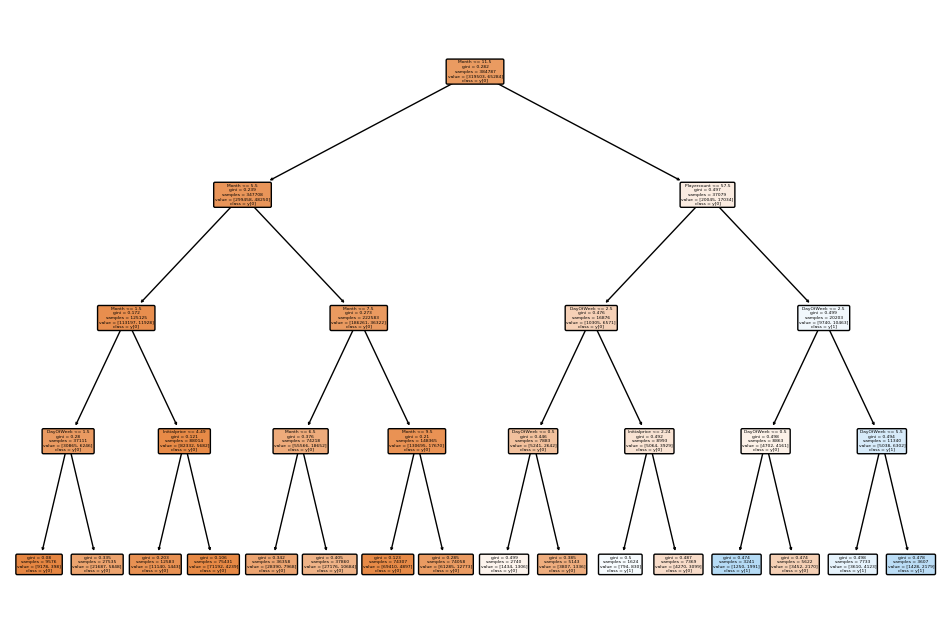

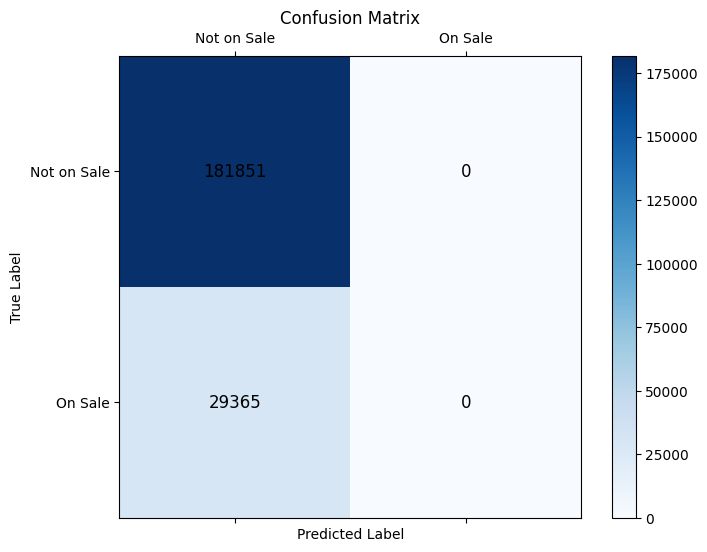

Depth: 4
Training: 0.8356415367463038
Testing: 0.8609717066888872




In [32]:
clf = DecisionTreeClassifier(max_depth=4,min_samples_leaf=split)
clf.fit(X_train, y_train)
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
plt.show()
y_predict = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_predict)

y_predict = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_predict)

cm = confusion_matrix(y_test, y_predict)

# Display the confusion matrix as a heatmap using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)

# Set labels for the confusion matrix
classes = ['Not on Sale', 'On Sale']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Display the values in each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

print("Depth: 4")
print("Training:", train_acc)
print("Testing:", test_acc)
print("\n")